# Analyses

In [1]:
%matplotlib inline

from utils.plot_utils import compare_parts_doggos, qual_helper, pearsonr_ci, get_questionnaire_dataframe
from utils.plot_utils import regplot_helper, readibility_helper, helper_k, lines, bars_plotter
from utils.plot_utils import big_plot_helper, table_helper, group_by_count, compare_parts
from utils.categories import SetTokens
from utils.hopper import Hopper
from itertools import product, combinations
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib import patches
import networkx as nx
import seaborn as sns
import pandas as pd
import numpy as np
import textstat
import warnings

warnings.filterwarnings('ignore')
sns.set_style(style="whitegrid")
sns.set_context("paper")


# Setup

In [2]:
num_hops = 5

topics = ["breast", "cardio", "diet", "immunization"]

qualifications = ["breast:3KSRR0ANT0SQYOX6MT2LB8HJ8EFCHJ", "cardio:3RJTH7YUGU2T60P6IF1ZMICQMWRYTM",
                  "nutrition:36FDFKUBEQYUVKNYWYMXNPALOD93NJ", "immunization:3RVVHO1V7S1LCQ80JEK422CLLUJWGC"]

# =====================================================================
# This normalizes things such that each sub-categorie counts the same
# =====================================================================

weights_categories = {"Participants": 1 / 5, "Intervention": 1 / 4, "Outcomes": 1 / 3, "Conclusion": 1}
weights_categories_tag = {"Participants": 1 / 5, "Intervention": 1 / 4, "Outcomes": 1 / 3, "Conclusion": 1}

# ===================================================================
# This relates to the questions in the qualification questionnaires
# ===================================================================

true_or_false = {
    "breast": ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13"],
    "cardio": ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13"],
    "immunization": ["1", "2", "3", "4", "5", "6", "7", "8"],
    "diet": ['1_1', '1_2', '1_3', '1_4', '1_5', '1_6', '1_7', '1_8', '2', '3_1',
             '3_2', '3_3', '4', '5', '6', '7', '8', '9']
}
# ==================================
# Maps values to a nice phrase :)
# ==================================

mapping_vals = {"A": "A: Fact captured", "B": "B: Fact partially captured", "C": "C: Fact not captured",
                "D": "D: Fact contradicts the text", "Keyphrases": "Keyphrases"}

# =========================
# Color map for the plots
# ========================= 

colors_map = {"A": "#226666", "B": "#552700", "C": "#2D882D", "D": "#AA3939", "Participants": "#276666",
              "Intervention": "#d29460", "Outcomes": "#ef88bf", "Conclusion": "#a83c3b", "Keyphrases": "#4C72B0",
              None: "#4C72B0"}

# ===========================
# Maps branches into papers
# ===========================

branch_to_topic = {
    "NEJMoa1000727": "breast", "NEJMoa1103507": "breast", "NEJMoa1206809": "breast",
    "NEJMoa1404037": "breast", "NEJMoa072761": "cardio", "NEJMoa1003114": "cardio",
    "NEJMoa1003833": "cardio", "NEJMoa1304127": "cardio", "NEJMoa0804748": "diet",
    "NEJMoa1014296": "diet", "NEJMoa1112010": "diet", "NEJMoa1200303": "diet",
    "NEJMoa021134": "immunization", "NEJMoa0907413": "immunization",
    "NEJMoa1102287": "immunization", "NEJMoa1200850": "immunization"
}

# =================================================
# These helpers are useful to the doggos analyses
# =================================================

category_helper_tag = {
    "Coarse": ["Participants", "Intervention", "Outcomes"],
    "Fine": ["Sex", "Age", "Condition", "Sample-size", "Location",
             "Outcomes-general", "Duration", "Intensity", "Control",
             "Intervention-general", "Effect-strength", "Adverse-effects"]
}

hierarchy_helper_tag = {
    "Hierarchy": {"Coarse": "Fine"},
    "Hierarchy_Mapping": {
        "Fine-Coarse": {"Sex": "Participants", "Age": "Participants",
                        "Condition": "Participants", "Sample-size": "Participnts",
                        "Location": "Participants", "Duration": "Intervention",
                        "Intervention-general": "Intervention", "Intensity": "Intervention",
                        "Control": "Intervention", "Outcomes-general": "Outcomes",
                        "Effect-strength": "Outcomes", "Adverse-effects": "Outcomes"
                        }
    }
}

category_helper = {
    "Coarse": ["Participants", "Intervention", "Outcomes", "Conclusion"],
    "Fine": ["Sex", "Age", "Condition", "Sample-size", "Location",
             "Intervention-general", "Duration", "Intensity", "Control",
             "Outcomes-general", "Effect-strength", "Adverse-effects",
             "Conclusion-general"
             ]
}

hierarchy_helper = {
    "Hierarchy": {"Coarse": "Fine"},
    "Hierarchy_Mapping": {
        "Fine-Coarse": {"Sex": "Participants", "Age": "Participants", "Condition": "Participants",
                        "Sample-size": "Participants", "Location": "Participants", "Duration":
                            "Intervention", "Intensity": "Intervention", "Control": "Intervention",
                        "Effect-strength": "Outcomes", "Adverse-effects": "Outcomes",
                        "Outcomes-general": "Outcomes", "Intervention-general": "Intervention",
                        "Conclusion-general": "Conclusion"
                        },
        "Coarse-Fine": {"Participants": ["Sex", "Age", "Condition", "Sample-size", "Location"],
                        "Intervention": ["Intervention-general", "Duration",
                                         "Intensity", "Control"],
                        "Outcomes-general": ["Conclusion-general", "Intensity", "Control",
                                             "Effect-strength", "Adverse-effects"],
                        "Conclusion": ["Conclusion-general"]
                        }
    }
}


Loads the graphs :)

In [3]:
hopper = Hopper()
hopper.g = nx.read_gpickle("./data/iterative_cascades.gpickle")
hopper.num_hops = num_hops
hopper_control = Hopper()
hopper_control.g = nx.read_gpickle("./data/control_cascades.gpickle")
hopper_control.num_hops = num_hops


# Telephone Effect

In our first analysis, we compare the distortion of information in the cascading and control conditions.

## Coarse

We begin obtaining two dataframes: `df_plots` and `df_props`. 

In [4]:
def tmp_root(root):
    return root["Doggos_crowd"]["Fine"]


def tmp_node(node, root):
    return node["Doggos_crowd"]["Fine"]


df_1 = hopper.get_tagging_dataframe_list(tmp_node, hierarchy_helper=hierarchy_helper, f_root=tmp_root)
df_1["control"] = 0
df_2 = hopper_control.get_tagging_dataframe_list(tmp_node, hierarchy_helper=hierarchy_helper, f_root=tmp_root)
df_2["control"] = 1
df = pd.concat([df_1, df_2])
df_props = df.groupby(["hop", "control", "key_coarse", "val"]).sum().reset_index()
df_norm = df.groupby(["hop", "val", "control"]).sum().reset_index()

df_props["count"] = df_props.apply(lambda x: dict(x)["count"] /
                                             df_norm[(df_norm.hop == dict(x)["hop"]) &
                                                     (df_norm.val == dict(x)["val"]) &
                                                     (df_norm.control == dict(x)["control"])]["count"].values[0],
                                   axis=1)

df_plots = group_by_count(df, ["hop", "control", "branch", "key_coarse"], "val", "count")


The first containts the percentage of facts retained for each hop, branch and category:

In [5]:
df_plots.head(4)


,hop,control,branch,key_coarse,val,count
0,0,0,NEJMoa021134,Conclusion,A,1.0
1,0,0,NEJMoa021134,Conclusion,B,0.0
2,0,0,NEJMoa021134,Conclusion,C,0.0
3,0,0,NEJMoa021134,Conclusion,D,0.0


The latter contains the distribution of values at each hop for each category:

In [6]:
df_props[(df_props.hop == 4) & (df_props.key_coarse == "Conclusion") & (df_props.control == 0)].head()


,hop,control,key_coarse,val,count
130,4,0,Conclusion,A,0.084746
131,4,0,Conclusion,B,0.236948
132,4,0,Conclusion,C,0.047833
133,4,0,Conclusion,D,0.447368


We do the same for the keyphrases:

In [7]:
def tmp_root(root):
    return root["Tagging"].get_occurrences("Coarse", relative=False)


def tmp_nodes(x, root):
    return x["Tagging"].get_occurrences("Coarse", relative=False)


df_1_token = hopper.get_tagging_dataframe(tmp_nodes, tmp_root)
df_2_token = hopper_control.get_tagging_dataframe(tmp_nodes, tmp_root)
df_1_token["control"] = 0
df_2_token["control"] = 1
df_tag = pd.concat([df_1_token, df_2_token])
df_diff_treatment_tag = df_tag[df_tag.control == 0].sort_values(["hop", "control", "branch", "key"])
df_plots_tag = df_tag[df_tag.control == 1].sort_values(["hop", "control", "branch", "key"])
df_plots_tag["diff"] = (df_diff_treatment_tag["val_norm"].values - df_plots_tag["val_norm"].values)
df_plots_tag["reduction"] = df_plots_tag["hop"]
df_props_tag = df_tag.groupby(["hop", "control", "key"]).sum().reset_index()
df_norm_tag = df_tag.groupby(["hop", "control"]).sum().reset_index()
df_props_tag["count"] = df_props_tag.apply(
    lambda x: dict(x)["val_norm"] / df_norm_tag[(df_norm_tag.hop == dict(x)["hop"]) &
                                                (df_norm_tag.control == dict(x)["control"])]["val_norm"].values[0],
    axis=1)


In [8]:
df_plots_tag.head(4)


,branch,hop,key,node,val,val_norm,control,diff,reduction
1843,NEJMoa021134,0,Intervention,NEJMoa021134,3,1.0,1,0.0,0
1844,NEJMoa021134,0,Outcomes,NEJMoa021134,6,1.0,1,0.0,0
1842,NEJMoa021134,0,Participants,NEJMoa021134,3,1.0,1,0.0,0
982,NEJMoa072761,0,Intervention,NEJMoa072761,3,1.0,1,0.0,0


In [9]:
df_props_tag[(df_props_tag.hop == 4) & (df_props_tag.control == 0)].head()


,hop,control,key,val,val_norm,count
24,4,0,Intervention,98,24.971212,0.398721
25,4,0,Outcomes,91,19.909524,0.317900
26,4,0,Participants,76,17.747619,0.283380


We use these dataframes to calculate the percentage of keyphrases in the summaries of a given hop and the percentage of facts with a given value for all papers in the cascading and control settings.
We depict the difference between these for different target lengths in **percentage points** in the line plots below.
Values above $0\%$ mean that the percentage of keyphrases or facts of a given value is higher in the cascading summaries. 


In [10]:
plots = [df_plots["key_coarse"] != "Bla", df_plots["key_coarse"] == "Participants",
         df_plots["key_coarse"] == "Intervention", df_plots["key_coarse"] == "Outcomes",
         df_plots["key_coarse"] == "Conclusion"]

plots_tags = [df_plots_tag.key != "Bla", df_plots_tag.key == "Participants",
              df_plots_tag.key == "Intervention", df_plots_tag.key == "Outcomes", None]

super_categories = [None, "Participants", "Intervention", "Outcomes", "Conclusion"]

y_ticks_helper = [([-0.15, -0.075, 0, 0.075, 0.15], ["-15%", "-7.5%", "0%", "7.5%", "15%"], [-0.15, 0.15]),
                  ([-0.15, -0.075, 0, 0.075, 0.15], ["-15%", "-7.5%", "0%", "7.5%", "15%"], [-0.15, 0.15]),
                  ([-0.15, -0.075, 0, 0.075, 0.15], ["-15%", "-7.5%", "0%", "7.5%", "15%"], [-0.15, 0.15]),
                  ([-0.15, -0.075, 0, 0.075, 0.15], ["-15%", "-7.5%", "0%", "7.5%", "15%"], [-0.15, 0.15]),
                  ([-0.30, -0.15, 0, 0.15, 0.30], ["-30%", "-15%", "0%", "15%", "30%"], [-0.30, 0.30])]

x_ticks_helper = [([0, 1, 2, 3, 4, 5], ["", "", "500", "250", "125", "64"], [2, 5])]


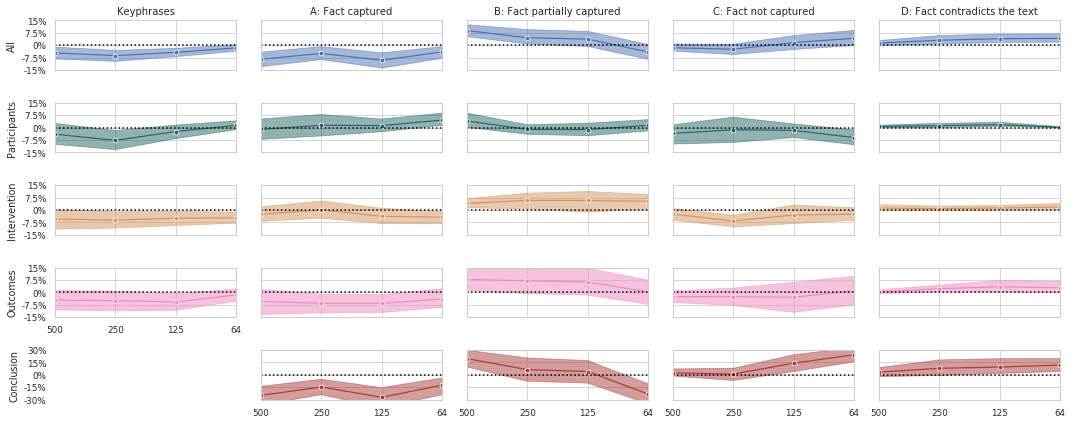

In [11]:
fig, axszes = plt.subplots(5, 5, figsize=(15, 6))

axszes_tokens = axszes[:, 0]
axszes = axszes[:, 1:]
for val_idx in range(5):
    axs = axszes[val_idx]

    df_plot = df_plots[plots[val_idx]]
    df_diff_treatment = df_plot[df_plot.control == 0].sort_values(["hop", "control", "branch", "key_coarse"])
    df_diff_control = df_plot[df_plot.control == 1].sort_values(["hop", "control", "branch", "key_coarse"])
    df_diff_control["diff"] = (df_diff_treatment["count"].values - df_diff_control["count"].values)
    df_diff_control["reduction"] = df_diff_control["hop"]

    t_stack, c_stack = [], []
    for idx, val in enumerate(["A", "B", "C", "D"]):
        big_plot_helper(df_diff_treatment, t_stack, df_diff_control, c_stack, val, axs[idx],
                        colors_map[super_categories[val_idx]], "", mapping_vals[val], val_idx == 0,
                        y_ticks_helper[val_idx], False, x_ticks_helper[0], val_idx == 4,
                        super_categories[val_idx], False)

    if plots_tags[val_idx] is None:
        plt.sca(axszes_tokens[val_idx])
        axszes_tokens[val_idx].set_frame_on(False)
        axszes_tokens[val_idx].grid(False)
        plt.xticks([], [])
        plt.yticks(y_ticks_helper[val_idx][0], y_ticks_helper[val_idx][1])
        plt.ylim(y_ticks_helper[val_idx][2])
        plt.ylabel(super_categories[val_idx])
    else:
        df_plot_tag = df_plots_tag[plots_tags[val_idx]]
        big_plot_helper(None, None, None, None, None, axszes_tokens[val_idx],
                        colors_map[super_categories[val_idx]], "", "Keyphrases", val_idx == 0,
                        y_ticks_helper[val_idx], True, x_ticks_helper[0], val_idx == 3,
                        super_categories[val_idx] if super_categories[val_idx] is not None else "All",
                        True, df_tag=df_plot_tag)

fig.tight_layout()
plt.savefig("./images/telephone_effect_coarse.pdf")


We also observe how the distribution of categories differ for the distinct settings, which we visualize as tables below.

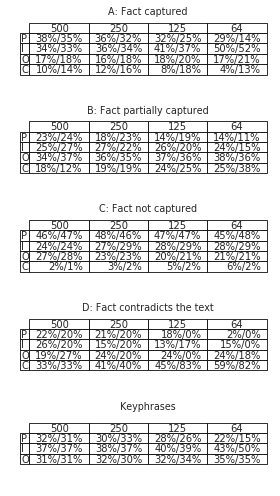

In [12]:
fig, axszes = plt.subplots(5, 1, figsize=(4, 7))
all_stack = []

for idx, val in enumerate(["A", "B", "C", "D"]):
    t_stack, c_stack = [], []
    for idy, val_super_cat in enumerate(["Participants", "Intervention", "Outcomes", "Conclusion"]):
        t_stack.append(df_props[(df_props.val == val) & (df_props.key_coarse == val_super_cat) &
                                (df_props.control == 0)]["count"])
        c_stack.append(df_props[(df_props.val == val) & (df_props.key_coarse == val_super_cat) &
                                (df_props.control == 1)]["count"])

    table_helper(t_stack, c_stack, row_labels=["P", "I", "O", "C"],
                 col_labels=["500", "250", "125", "64"], number_cols=4, ax=axszes[idx])

    axszes[idx].set_title(mapping_vals[val])

t_stack, c_stack = [], []
for idy, val_super_cat in enumerate(["Participants", "Intervention", "Outcomes"]):
    t_stack.append(df_props_tag[(df_props_tag.key == val_super_cat) & (df_props_tag.control == 0)]["count"])
    c_stack.append(df_props_tag[(df_props_tag.key == val_super_cat) & (df_props_tag.control == 1)]["count"])

table_helper(t_stack, c_stack, row_labels=["P", "I", "O"],
             col_labels=["500", "250", "125", "64"], number_cols=3, ax=axszes[4])
axszes[4].set_title(mapping_vals["Keyphrases"])

fig.tight_layout()


## Fine

Analyzing the coarse categories, we find evidence above that more is lost in the cascading summaries and that the messages that get passed differ. We zoom into the fine categories to drill deeper in this regard.

In [13]:
# DOGGOS


def tmp_root(root):
    return root["Doggos_crowd"]["Fine"]


def tmp_node(node, root):
    return node["Doggos_crowd"]["Fine"]


df_1 = hopper.get_tagging_dataframe_list(tmp_node, hierarchy_helper=hierarchy_helper, f_root=tmp_root,
                                         output_nodes=True)
df_1["control"] = 0
df_2 = hopper_control.get_tagging_dataframe_list(tmp_node, hierarchy_helper=hierarchy_helper, f_root=tmp_root,
                                                 output_nodes=True)
df_2["control"] = 1
df = pd.concat([df_1, df_2])
# Average
df_plot_fine = group_by_count(df, ["hop", "control", "branch", "key"], "val", "count")
df_diff_treatment_fine = df_plot_fine[df_plot_fine.control == 0].sort_values(["hop", "control", "branch", "key"])
df_diff_control_fine = df_plot_fine[df_plot_fine.control == 1].sort_values(["hop", "control", "branch", "key"])
df_diff_control_fine["diff"] = (df_diff_treatment_fine["count"].values - df_diff_control_fine["count"].values)
df_diff_control_fine["reduction"] = df_diff_control_fine["hop"]
# Best
df_custom = df.groupby(["branch", "node", "key", "control", "hop"]) \
    .apply(lambda x: x[x.val == "A"]["count"].sum()).to_frame().reset_index()
df_custom["father"] = df_custom.node.apply(lambda x: "_".join(x.split("_")[:-1]))
df_custom = df_custom.rename({0: "val"}, axis='columns')
df_t = helper_k(df_custom, 0, category_helper, branch_to_topic, df, num_hops)
df_plot_fine_top = group_by_count(df_t, ["hop", "control", "branch", "key"], "val", "count")
df_diff_treatment_fine_top = df_plot_fine_top[df_plot_fine_top.control == 0].sort_values(["hop", "control",
                                                                                          "branch", "key"])
df_diff_control_fine_top = df_plot_fine_top[df_plot_fine_top.control == 1].sort_values(["hop", "control",
                                                                                        "branch", "key"])
df_diff_control_fine_top["diff"] = df_diff_treatment_fine_top["count"].values - \
                                   df_diff_control_fine_top["count"].values
df_diff_control_fine_top["reduction"] = df_diff_control_fine_top["hop"]
# Worse
df_custom = df.groupby(["branch", "node", "key", "control", "hop"]) \
    .apply(lambda x: x[x.val == "A"]["count"].sum()).to_frame().reset_index()
df_custom["father"] = df_custom.node.apply(lambda x: "_".join(x.split("_")[:-1]))
df_custom = df_custom.rename({0: "val"}, axis='columns')
df_t = helper_k(df_custom, -1, category_helper, branch_to_topic, df, num_hops)
df_plot_fine_bot = group_by_count(df_t, ["hop", "control", "branch", "key"], "val", "count")
df_diff_treatment_fine_bot = df_plot_fine_bot[df_plot_fine_bot.control == 0] \
    .sort_values(["hop", "control", "branch", "key"])
df_diff_control_fine_bot = df_plot_fine_bot[df_plot_fine_bot.control == 1] \
    .sort_values(["hop", "control", "branch", "key"])
df_diff_control_fine_bot["diff"] = df_diff_treatment_fine_bot["count"].values - \
                                   df_diff_control_fine_bot["count"].values
df_diff_control_fine_bot["reduction"] = df_diff_control_fine_bot["hop"]


The above cell creates the percentage of facts retained per each hop. It also considers the "best ancestor" and "worse ancestor" scenarios!

In [14]:
df_diff_control_fine[(df_diff_control_fine.branch == "NEJMoa021134") &
                     (df_diff_control_fine.key == "Conclusion-general")].head(8)


,hop,control,branch,key,val,count,diff,reduction
840,0,1,NEJMoa021134,Conclusion-general,A,1.0,0.0,0
841,0,1,NEJMoa021134,Conclusion-general,B,0.0,0.0,0
842,0,1,NEJMoa021134,Conclusion-general,C,0.0,0.0,0
843,0,1,NEJMoa021134,Conclusion-general,D,0.0,0.0,0
2265,1,1,NEJMoa021134,Conclusion-general,A,1.0,0.0,1
2266,1,1,NEJMoa021134,Conclusion-general,B,0.0,0.0,1
2267,1,1,NEJMoa021134,Conclusion-general,C,0.0,0.0,1
2268,1,1,NEJMoa021134,Conclusion-general,D,0.0,0.0,1


We do the same for keyphrases!

In [15]:
# TOKENS 


def tagging(x, root):
    return x["Tagging"].get_occurrences("Fine", relative=False)


def tagging_root(root):
    return root["Tagging"].get_occurrences("Fine", relative=False)


df_1 = hopper.get_tagging_dataframe(tagging, tagging_root)
df_2 = hopper_control.get_tagging_dataframe(tagging, tagging_root)
df_1["control"] = 0
df_2["control"] = 1
df_tag_fine = pd.concat([df_1, df_2])
# Average
df_diff_treatment_fine_tag = df_tag_fine[df_tag_fine.control == 0] \
    .sort_values(["hop", "control", "branch", "key"])
df_diff_control_fine_tag = df_tag_fine[df_tag_fine.control == 1].sort_values(["hop", "control", "branch", "key"])
df_diff_control_fine_tag["diff"] = (df_diff_treatment_fine_tag["val_norm"].values \
                                    - df_diff_control_fine_tag["val_norm"].values)
df_diff_control_fine_tag["reduction"] = df_diff_control_fine_tag["hop"]
# Best
df_custom = df_tag_fine.groupby(["branch", "node", "key", "control", "hop"]) \
    .apply(lambda x: x["val_norm"].sum()).to_frame().reset_index()
df_custom["father"] = df_custom.node.apply(lambda x: "_".join(x.split("_")[:-1]))
df_custom = df_custom.rename({0: "val"}, axis='columns')
df_t = helper_k(df_custom, 0, category_helper_tag, branch_to_topic, df_tag_fine, num_hops)
df_diff_treatment_fine_tag_top = df_t[df_t.control == 0].sort_values(["hop", "control", "branch", "key"])
df_diff_control_fine_tag_top = df_t[df_t.control == 1].sort_values(["hop", "control", "branch", "key"])
df_diff_control_fine_tag_top["diff"] = (df_diff_treatment_fine_tag_top["val_norm"].values \
                                        - df_diff_control_fine_tag_top["val_norm"].values)
df_diff_control_fine_tag_top["reduction"] = df_diff_control_fine_tag_top["hop"]
# Worst
df_custom = df_tag_fine.groupby(["branch", "node", "key", "control", "hop"]) \
    .apply(lambda x: x["val_norm"].sum()).to_frame().reset_index()
df_custom["father"] = df_custom.node.apply(lambda x: "_".join(x.split("_")[:-1]))
df_custom = df_custom.rename({0: "val"}, axis='columns')
df_t = helper_k(df_custom, -1, category_helper_tag, branch_to_topic, df_tag_fine, num_hops)
df_diff_treatment_fine_tag_bot = df_t[df_t.control == 0].sort_values(["hop", "control", "branch", "key"])
df_diff_control_fine_tag_bot = df_t[df_t.control == 1].sort_values(["hop", "control", "branch", "key"])
df_diff_control_fine_tag_bot["diff"] = (df_diff_treatment_fine_tag_bot["val_norm"].values \
                                        - df_diff_control_fine_tag_bot["val_norm"].values)
df_diff_control_fine_tag_bot["reduction"] = df_diff_control_fine_tag_bot["hop"]


In [16]:
df_diff_control_fine_tag_bot[(df_diff_control_fine_tag_bot.branch == "NEJMoa021134") &
                             (df_diff_control_fine_tag_bot.key == "Intervention-general")].head(8)


,node,key,branch,hop,val,val_norm,control,diff,reduction
9873,NEJMoa021134,Intervention-general,NEJMoa021134,0,1,1.0,1,0.0,0
9393,NEJMoa021134_3PS7W85Z80NO5VSK9TX20BURQDGT9I,Intervention-general,NEJMoa021134,1,1,1.0,1,0.0,1
9405,NEJMoa021134_3L6L49WXW1ILNNBIR2JDGNDXOJ545X,Intervention-general,NEJMoa021134,1,1,1.0,1,0.0,1
9417,NEJMoa021134_32ZKVD547G82U79NSY5794LJKFIB37,Intervention-general,NEJMoa021134,1,1,1.0,1,0.0,1
9429,NEJMoa021134_30OG32W0SVW75EEHK8RCJQPASUSENY,Intervention-general,NEJMoa021134,1,1,1.0,1,0.0,1
9441,NEJMoa021134_36AHBNMV1SXWP74VVFP3UO5WW20YDK,Intervention-general,NEJMoa021134,1,1,1.0,1,0.0,1
9453,NEJMoa021134_3TEM0PF1Q6IZSC8AN7EU2WBCKPWD09,Intervention-general,NEJMoa021134,1,1,1.0,1,0.0,1
9465,NEJMoa021134_3HYA4D452S43M6PKT0DY9K7CT0PF2Z,Intervention-general,NEJMoa021134,1,1,1.0,1,0.0,1


Lastly, in the plot below, we show the differences in the percentage of facts and keyphrases between cascading and control summaries for fine-grained categories. The positive side of the $x$-axis (in gray) means that percentage of facts\slash keyphrases for that category was higher in the cascading scenario. Each category is associated with three values (with bootstrapped 95\% CIs) with different markers. The circle $\circ$ represents the actual difference between cascading and control settings. The upward $\triangle$ (downward $\triangledown$) triangle represents the difference between the successor of the best (worst) cascading summary from the previous hop and control. 

In [17]:
def lines(axs):
    plt.sca(axs)
    axs.axhline(y=3 * 0.5 + 1, color="black", alpha=0.8)

    axs.axhline(y=3 * 3.5 + 1, color="black", alpha=0.8)

    axs.axhline(y=3 * 7.5 + 1, color="black", alpha=0.8)
    axs.axhline(y=3 * 13.5 + 1, color="black", alpha=0.8)

    axs.fill_between([0, 0.5], [-.5, -.5], [3 * 12.5 + 1, 3 * 12.5 + 1], facecolor="black", alpha=0.15)
    for v in np.arange(-0.5, 3 * 12.5 + 1, 3):
        axs.axhline(y=v, color="black", alpha=0.4)


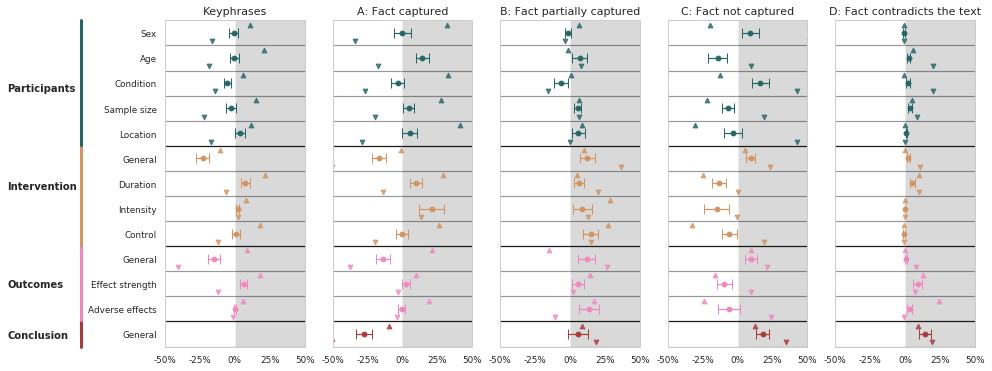

In [18]:
fig, axszes = plt.subplots(1, 5, figsize=(15, 6), sharey=True)

y_ticks_helper = [([-0.50, -0.25, 0, 0.25, 0.50], ["-50%", "-25%", "0%", "25%", "50%"], [-0.5, 0.5]),
                  ([-0.50, -0.25, 0, 0.25, 0.50], ["-50%", "-25%", "0%", "25%", "50%"], [-0.5, 0.5])]

for idx, val in enumerate(["Keyphrases", "A", "B", "C", "D"]):
    # ORIGINAL
    if val is not "Keyphrases":
        df_tmp_fine = df_diff_control_fine[df_diff_control_fine.val == val]
        df_tmp_fine["key_coarse"] = df_tmp_fine.key.apply(
            lambda x: hierarchy_helper["Hierarchy_Mapping"]["Fine-Coarse"][x])
    else:
        df_tmp_fine = df_diff_control_fine_tag
    bars_plotter(df_tmp_fine, category_helper, val, colors_map, hierarchy_helper, axszes[idx],
                 helper_idy=lambda idy: idy * 3 + 1, alpha=1)
    # TOP
    if val is not "Keyphrases":
        df_tmp_fine = df_diff_control_fine_top[df_diff_control_fine_top.val == val]
        df_tmp_fine["key_coarse"] = df_tmp_fine.key.apply(
            lambda x: hierarchy_helper["Hierarchy_Mapping"]["Fine-Coarse"][x])
    else:
        df_tmp_fine = df_diff_control_fine_tag_top
    bars_plotter(df_tmp_fine, category_helper, val, colors_map, hierarchy_helper, axszes[idx],
                 helper_idy=lambda idy: idy * 3 + 2, alpha=0.8, marker="^", is_err=False)
    # BOT
    if val is not "Keyphrases":
        df_tmp_fine = df_diff_control_fine_bot[df_diff_control_fine_bot.val == val]
        df_tmp_fine["key_coarse"] = df_tmp_fine.key.apply(
            lambda x: hierarchy_helper["Hierarchy_Mapping"]["Fine-Coarse"][x])
    else:
        df_tmp_fine = df_diff_control_fine_tag_bot
    bars_plotter(df_tmp_fine, category_helper, val, colors_map, hierarchy_helper, axszes[idx],
                 helper_idy=lambda idy: idy * 3, alpha=0.8, marker="v", is_err=False)
    axszes[idx].set_xlabel("")
    axszes[idx].set_ylabel("")
    lines(axszes[idx])
    plt.sca(axszes[idx])
    plt.xlim(y_ticks_helper[0][2])
    plt.ylim(-0.5, 3 * 12.5 + 1)
    plt.xticks(y_ticks_helper[0][0], y_ticks_helper[0][1])
    plt.yticks(np.array(list(range(len(category_helper["Fine"])))) * 3 + 1, 
               ["Sex", "Age", "Condition", "Sample size", "Location",
               "General", "Duration", "Intensity", "Control",
               "General", "Effect strength", "Adverse effects",
               "General"][::-1])
    plt.title(mapping_vals[val], fontsize=11)
    plt.grid(False)
    axszes[idx].set_facecolor((1, 1, 1))

fig.subplots_adjust(left=0.15)
trans = axszes[0].get_xaxis_transform() # x in data untis, y in axes fraction
ann = axszes[0].annotate('Conclusion', xy=(-1.63,0.027), xycoords=trans, fontweight="bold")
ann = axszes[0].annotate('Outcomes', xy=(-1.63,0.183), xycoords=trans, fontweight="bold")
ann = axszes[0].annotate('Intervention', xy=(-1.63,0.483), xycoords=trans, fontweight="bold")
ann = axszes[0].annotate('Participants', xy=(-1.63,0.783), xycoords=trans, fontweight="bold")
axszes[0].plot([-1.1,-1.1 ], [0,0.08 ], transform=trans, clip_on=False, lw=3, color=colors_map["Conclusion"])
axszes[0].plot([-1.1,-1.1 ], [0.08,0.31 ], transform=trans, clip_on=False, lw=3, color=colors_map["Outcomes"])
axszes[0].plot([-1.1,-1.1 ], [0.31,0.617 ], transform=trans, clip_on=False, lw=3,
               color=colors_map["Intervention"])
axszes[0].plot([-1.1,-1.1 ], [0.617,1 ], transform=trans, clip_on=False, lw=3, 
               color=colors_map["Participants"])


# fig.tight_layout(h_pad=3)
plt.savefig("./images/telephone_effect_fine.pdf")


# Conditionals Message Distortion

Next, we calculate the **conditional chance of survival** for keyphrases and facts across hops. That is, given that a fact or a keyphrase is present in a given hop $k$, what is the chance that it will also be present in hop $k+1$? In the case of keyphrases, for a given summarization process and category, we define the survival probability as the percentage of keyphrases that continue to exist in the summary, out of those that already exist in the reference text. For instance, if there are three keyphrases in the **Outcomes** category in hop $1$, and two remain at hop $2$, the probability of survival for this category from hop 1 to hop 2 is $2/3$.  We also consider the influence of the number of difficult words in the original abstract on the survival of facts and keyphrases, and the influence of the number of difficult words in the original abstract on the survival of facts and keyphrases.

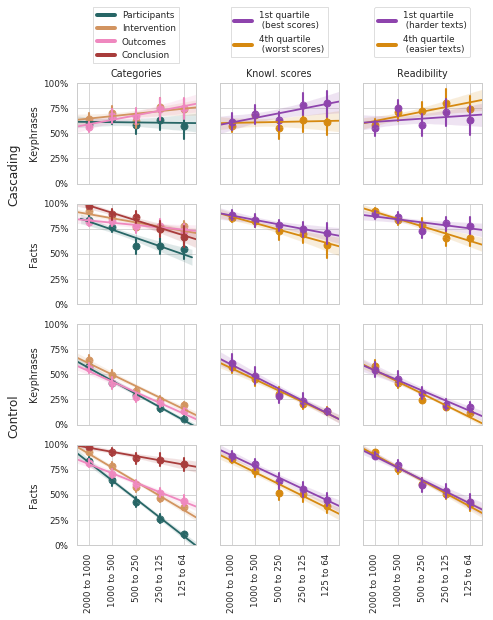

In [19]:
fig, axs = plt.subplots(4, 3, figsize=(7.5, 8.5), sharey=True, sharex=True)

for idx, h in enumerate([hopper, hopper_control]):
    df_doggos = h.get_tagging_hop_dataframe(
        lambda root, src, dst: compare_parts_doggos(root, src, dst, weights_categories))

    df_tag = h.get_tagging_hop_dataframe(lambda root, src, dst: compare_parts(root, src, dst, weights_categories))
    df_tag["Topic"] = df_tag.branch.apply(lambda x: branch_to_topic[x])

    for cat in category_helper["Coarse"]:
        df_doggos_tmp = df_doggos[df_doggos.key == cat]
        regplot_helper(color=[colors_map[cat]], df=df_doggos_tmp, axis=[axs[1 + 2 * idx][0]])

    for cat in category_helper_tag["Coarse"]:
        df_tag_tmp = df_tag[df_tag.key == cat]
        regplot_helper(color=[colors_map[cat]], df=df_tag_tmp, axis=[axs[0 + 2 * idx][0]])
    read_fun = textstat.difficult_words

    df_tag["Qualification"] = df_tag.dst.apply(lambda x: qual_helper(x, hopper, hopper_control))
    df_doggos["Qualification"] = df_doggos.dst.apply(lambda x: qual_helper(x, hopper, hopper_control))
    df_tag["Readibility"] = df_tag.branch.apply(
        lambda x: readibility_helper(x, read_fun, hopper, hopper_control))
    df_doggos["Readibility"] = df_doggos.branch.apply(
        lambda x: readibility_helper(x, read_fun, hopper, hopper_control))

    df_tag = df_tag[df_tag.key != "All"]
    df_doggos = df_doggos[df_doggos.key != "All"]

    for i in range(1, 6):
        df_tag_tmp = df_tag.loc[(df_tag.hop == i)]
        df_doggos_tmp = df_doggos.loc[(df_doggos.hop == i)]

        for col, new_col in [("Qualification", "Qualification_acc_p"), ("Readibility", "Readibility_p")]:
            quals = df_tag_tmp[col].values
            df_tag_tmp.loc[df_tag_tmp[col] < np.percentile(quals, 25), new_col] = "1st Quartile"
            df_tag_tmp.loc[df_tag_tmp[col] > np.percentile(quals, 75), new_col] = "4th Quartile"
            df_tag.loc[df_tag.hop == i, new_col] = df_tag_tmp[new_col]

            quals = df_doggos_tmp[col].values
            df_doggos_tmp.loc[df_doggos_tmp[col] < np.percentile(quals, 25), new_col] = "1st Quartile"
            df_doggos_tmp.loc[df_doggos_tmp[col] > np.percentile(quals, 75), new_col] = "4th Quartile"
            df_doggos.loc[df_doggos.hop == i, new_col] = df_doggos_tmp[new_col]

    regplot_helper(color=["#D68910", "#8E44AD"], df=df_tag, axis=[axs[0 + 2 * idx][1], axs[0 + 2 * idx][1]],
                   row="Qualification_acc_p", value=["1st Quartile", "4th Quartile"])
    regplot_helper(color=["#D68910", "#8E44AD"], df=df_doggos, axis=[axs[1 + 2 * idx][1], axs[1 + 2 * idx][1]],
                   row="Qualification_acc_p", value=["1st Quartile", "4th Quartile"])
    regplot_helper(color=["#D68910", "#8E44AD"], df=df_tag, axis=[axs[0 + 2 * idx][2], axs[0 + 2 * idx][2]],
                   row="Readibility_p", value=["1st Quartile", "4th Quartile"])
    regplot_helper(color=["#D68910", "#8E44AD"], df=df_doggos, axis=[axs[1 + 2 * idx][2], axs[1 + 2 * idx][2]],
                   row="Readibility_p", value=["1st Quartile", "4th Quartile"])

custom_lines = [Line2D([0], [0], color=colors_map[cat], lw=4) for cat in category_helper["Coarse"]]
axs[0][0].legend(custom_lines, category_helper["Coarse"], loc='upper center', bbox_to_anchor=(0.5, 1.8),
                 fancybox=False, shadow=False, ncol=1)

custom_lines = [Line2D([0], [0], color=col, lw=4) for col in ["#8E44AD", "#D68910"]]
axs[0][1].legend(custom_lines, ["1st quartile \n (best scores)", "4th quartile \n (worst scores)"],
                 loc='upper center', bbox_to_anchor=(0.5, 1.8),
                 fancybox=False, shadow=False, ncol=1)

custom_lines = [Line2D([0], [0], color=col, lw=4) for col in ["#8E44AD", "#D68910"]]
axs[0][2].legend(custom_lines, ["1st quartile \n (harder texts)", "4th quartile \n (easier texts)"],
                 loc='upper center', bbox_to_anchor=(0.5, 1.8),
                 fancybox=True, shadow=False, ncol=1)

plt.yticks([0.0, 0.25, 0.50, 0.75, 1], ["0%", "25%", "50%", "75%", "100%"])
plt.xlim([0.5, 5.5])
plt.ylim([0, 1])

for idy in range(3):
    for idx in range(4):
        axs[idx][idy].set_xlabel("")
        axs[idx][idy].set_ylabel("")
    plt.sca(axs[3][idy])
    plt.xticks([1, 2, 3, 4, 5], ["2000 to 1000", "1000 to 500", "500 to 250", "250 to 125", "125 to 64"], 
               rotation=90)

axs[0][0].set_ylabel("Keyphrases")
axs[1][0].set_ylabel("Facts")
axs[2][0].set_ylabel("Keyphrases")
axs[3][0].set_ylabel("Facts")

# axs[3][0].set_xlabel("Hop")
axs[0][0].set_title("Categories")
axs[0][1].set_title("Knowl. scores")
axs[0][2].set_title("Readibility")

for ax, row in zip([axs[0,0], axs[2,0]] , ["Cascading", "Control"]):
    ax.annotate(row, xy=(0, -0.25), xytext=(-ax.yaxis.labelpad - 5, 0),
    xycoords=ax.yaxis.label, textcoords='offset points',
    size='large', ha='right', va='center', rotation=90)
fig.subplots_adjust(left=0.15)

plt.savefig("./images/conditional_effect.pdf")


# Strategies

Another aspect that may influence distortion effects in information cascades is the summarization strategy employed. Here we compare abstractive and extractive summarization strategies. To be able to do so, we have to distinguish abstractive and extractive summmaries, as well as successful and unsuccessful ones.

To this end, we define **keyphrase scores** and **fact scores** for each of the summaries. The keyphrase score is defined as the percentage of keyphrases that the fact retained from the original abstract, whereas for fact scores we take a weighted average of the percentages of $A$- and $B$-valued facts retained from the original abstract (assigning weight $1$ to $A$-valued facts and weight $0.5$ to $B$-valued facts). 

With these newly defined scores, for each hop, we can plot the summary as a point in a two-dimensional plane. We depict the kernel density estimate of these points in the columns of the plot below. We consider that the points with high fact scores ($y$-axis) are better summaries, and that the points with high keyphrase scores ($x$-axis) are more extractive. These abstractions allows us to measure the quality and extractiveness of summaries.

In [20]:
def node_func(x, root):
    tmp = dict()
    root_aux = root["Tagging"].get_occurrences("Coarse", relative=False)
    top_token, bot_token, top_doggo, bot_doggo = 0, 0, 0, 0
    for key, item in x["Tagging"].get_occurrences("Coarse", relative=False).items():
        top_token += item * weights_categories_tag[key]
        bot_token += root_aux[key] * weights_categories_tag[key]
    for key in category_helper["Coarse"]:
        top_doggo += (x["Doggos_crowd"]["Coarse"][key].count('A') + 0.5 *
                      x["Doggos_crowd"]["Coarse"][key].count('B')) * weights_categories[key]
        bot_doggo += (root["Doggos_crowd"]["Coarse"][key].count('A') + 0.5 *
                        root["Doggos_crowd"]["Coarse"][key].count('B')) * weights_categories[key]
    tmp["All"] = (top_token / bot_token, top_doggo / bot_doggo)
    return tmp


def root_func(root):
    return {key: (1, 1) for key in root["Tagging"].get_occurrences("Coarse", relative=False).keys()}


df_tag_1 = hopper.get_tagging_dataframe(node_func, root_func, norm_enabled=False)
df_tag_1["control"] = 0
df_tag_2 = hopper_control.get_tagging_dataframe(node_func, root_func, norm_enabled=False)
df_tag_2["control"] = 1
df_tag = pd.concat([df_tag_1, df_tag_2])
df_tag["val_tokens"] = df_tag.val.apply(lambda x: x[0])
df_tag["val_doggos"] = df_tag.val.apply(lambda x: x[1])


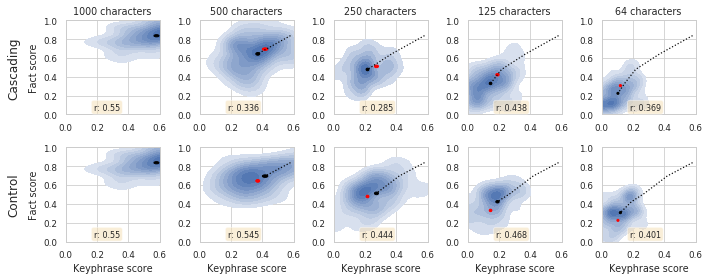

In [21]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
titles = ["1000", "500", "250", "125", "64"]
rows = ["Cascading", "Control"]
pad = 5

for control in [0, 1]:
    x_means, y_means = [], []
    for i in range(1, 6):
        tmp = df_tag[(df_tag.hop == i) & (df_tag.control == control)]
        x_mean, y_mean = np.mean(tmp.val_tokens), np.mean(tmp.val_doggos)
        ci_x = sns.utils.ci(sns.algorithms.bootstrap(tmp.val_tokens))
        ci_y = sns.utils.ci(sns.algorithms.bootstrap(tmp.val_doggos))
        e1 = patches.Ellipse(((ci_x[0] + ci_x[1]) / 2, (ci_y[0] + ci_y[1]) / 2), (ci_x[1] - ci_x[0]) / 2,
                             (ci_y[1] - ci_y[0]) / 2, linewidth=1, fill=True, color="black", zorder=2)
        axs[control][i - 1].add_patch(e1)
        if i != 1:
            e2 = patches.Ellipse(((ci_x[0] + ci_x[1]) / 2, (ci_y[0] + ci_y[1]) / 2), (ci_x[1] - ci_x[0]) / 2,
                                 (ci_y[1] - ci_y[0]) / 2, linewidth=1, fill=True, color="red", zorder=2)
            axs[abs(control - 1)][i - 1].add_patch(e2)
        r, p, lo, hi = pearsonr_ci(tmp.val_tokens, tmp.val_doggos)
        # print(lo, hi)
        x_means.append(x_mean)
        y_means.append(y_mean)
        sns.kdeplot(tmp.val_tokens, tmp.val_doggos, ax=axs[control][i - 1], color=colors_map["Keyphrases"],
                    shade=True, shade_lowest=False)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        axs[control][i - 1].text(0.18, 0.125, 'r: {0}'.format(round(r, 3)), fontsize=8, verticalalignment='top',
                                 bbox=props)
        axs[control][i - 1].set_xlim([0, 0.6])
        axs[control][i - 1].set_ylim([0, 1])
        axs[control][i - 1].set_title("{0} characters".format(titles[i - 1])) \
            if control == 0 else axs[control][i - 1].set_title("")
        axs[control][i - 1].set_xlabel("")
        axs[control][i - 1].set_ylabel("Fact score") if i == 1 else axs[control][i - 1].set_ylabel("")
        axs[control][i - 1].set_xlabel("Keyphrase score") if control == 1 else axs[control][i - 1].set_xlabel("")
        axs[control][i - 1].plot(x_means, y_means, color="black", linestyle=":")

for ax, row in zip(axs[:, 0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0), xycoords=ax.yaxis.label,
                textcoords='offset points', size='large', ha='right', va='center', rotation=90)
fig.tight_layout()
fig.subplots_adjust(left=0.10)
plt.savefig("./images/summarization_strategies.pdf")


Our last analysis is as follows: for each hop and abstract in the cascading setting, we match summaries in pairs. Summaries are only matched if 
**(i)** the relative difference in their keyphrase score is **greater** than $\alpha$ and 
**(ii)** the relative difference in their fact score is *less* than $\beta$. 

We only match each summary once, and we do so greedily. Within each pair, we consider the summary with the higher keyphrase score to be more extractive (while of similar quality). 
We then compare how the fact score of each summary in the pair decreases with the subsequent summarization. The idea is that if extractive texts lose more of their fact score than abstractive texts, this is evidence that extractive summarization is less effective (and vice versa).

We show the results for each of summarization step in the figure bellow for several values of $\alpha$ and $\beta$.

In [22]:
def tagging(x, root):
    tmp = dict()
    root_aux = root["Tagging"].get_occurrences("Coarse", relative=False)
    top_token, bot_token = 0, 0
    top_doggo, bot_doggo = 0, 0
    for key, item in x["Tagging"].get_occurrences("Coarse", relative=False).items():
        top_token += item * weights_categories_tag[key]
        bot_token += root_aux[key] * weights_categories_tag[key]
    for key in category_helper["Coarse"]:
        top_doggo += (x["Doggos_crowd"]["Coarse"][key].count('A') +
                      0.5 * x["Doggos_crowd"]["Coarse"][key].count('B')) * weights_categories[key]
        bot_doggo += (root["Doggos_crowd"]["Coarse"][key].count('A') +
                      0.5 * root["Doggos_crowd"]["Coarse"][key].count('B')) * weights_categories[key]
    tmp["All"] = (top_token / bot_token, top_doggo / bot_doggo)
    return tmp


def tagging_root(root):
    return {key: (1, 1) for key in root["Tagging"].get_occurrences("Coarse", relative=False).keys()}


other_lines = [(alpha, beta, None) for alpha, beta in
               list(product(np.arange(0.3, 0.71, 0.1), np.arange(0.05, 0.151, 0.025)))]


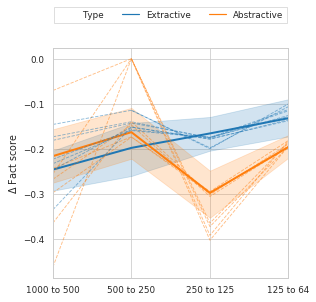

In [23]:
weights_categories_list = [({"Participants": 1/5, "Intervention": 1/4, "Outcomes": 1/3, "Conclusion": 1},
                            {"Participants": 1, "Intervention": 1/4, "Outcomes": 1/5})]

fig, axs = plt.subplots(1, 1, figsize=(4.5, 4.3))
lines_to_plot = [(0.3, 0.15, "band")] + \
                [(alpha, beta, None) for alpha, beta in
                 list(product(np.arange(0.3, 0.7, 0.1), np.arange(0.05, 0.15, 0.05)))]

for alpha, beta, err_style in lines_to_plot:
    for weights_categories, weights_categories_tag in weights_categories_list:
        df_tag_1 = hopper.get_tagging_dataframe(tagging, tagging_root, norm_enabled=False)
        df_tag_1["control"] = 0
        df_df_tag_1tag_2 = hopper_control.get_tagging_dataframe(tagging, tagging_root, norm_enabled=False)
        df_tag_2["control"] = 1
        df_tag = pd.concat([df_tag_1, df_tag_2])
        df_tag["val_tokens"] = df_tag.val.apply(lambda x: x[0])
        df_tag["val_doggos"] = df_tag.val.apply(lambda x: x[1])
        df_tag["node_aux"] = df_tag["node"]
        df_tag.set_index(["node"], inplace=True)
        count = 0
        tmp_df = []
        for i in range(1, 5):
            tmp = df_tag[(df_tag.hop == i) & (df_tag.control == 0)]
            for branch in branch_to_topic.keys():
                flag = []

                for idx, idy in combinations(range(8), 2):
                    if idx or idy in flag:
                        continue
                    extractive = dict(tmp[tmp.branch == branch].sort_values("val_doggos",
                                                                            ascending=False).iloc[idx])
                    abstractive = dict(tmp[tmp.branch == branch].sort_values("val_doggos",
                                                                             ascending=False).iloc[idy])
                    if extractive["val_tokens"] < abstractive["val_tokens"]:
                        tmp_ = extractive
                        extractive = abstractive
                        abstractive = tmp_
                    if extractive["val_tokens"] - abstractive["val_tokens"] < alpha* extractive["val_tokens"] \
                            or extractive["val_doggos"] - abstractive["val_doggos"] > \
                            max(beta * extractive["val_doggos"], beta * abstractive["val_doggos"]):
                        continue
                    succ_extractive = dict(df_tag.loc[list(hopper.g.successors(extractive["node_aux"]))[0]])
                    succ_abstractive = dict(df_tag.loc[list(hopper.g.successors(abstractive["node_aux"]))[0]])
                    tmp_df.append({"hop": i, "Type": "Extractive",
                                   "$\Delta$ Fact score": (succ_extractive["val_doggos"] -
                                                           extractive["val_doggos"])})
                    tmp_df.append({"hop": i, "Type": "Abstractive",
                                   "$\Delta$ Fact score": (succ_abstractive["val_doggos"] -
                                                           abstractive["val_doggos"])})
                    flag += [idx, idy]

        df_ana = pd.DataFrame(tmp_df)

        if err_style == "band":
            sns.lineplot(x="hop", y="$\Delta$ Fact score", hue="Type", data=df_ana, ax=axs,
                         color=["#8E44AD", "#D68910"], lw=2,
                         err_style=err_style)
        else:
            ax = sns.lineplot(x="hop", y="$\Delta$ Fact score", hue="Type", data=df_ana, ax=axs,
                              color=["#8E44AD", "#D68910"], lw=0.9,
                              err_style=None, legend=False, alpha=0.5)
            ax.lines[-1].set_linestyle("--")
            ax.lines[-2].set_linestyle("--")            

    plt.sca(axs)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=False, shadow=False, ncol=3)
    plt.xticks([1, 2, 3, 4], ["1000 to 500", "500 to 250", "250 to 125", "125 to 64"])
    plt.xlim([1, 4])
    plt.xlabel("")
    fig.tight_layout()
    plt.savefig("./images/summarization_strategies2.pdf")


---